In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

functions for the genetic algoritm

In [2]:
# generating a set of feasible solutions / cronosomes
# every gene is a level where there is a call, the elements are the order in wich they are answered
def generateChronosome(size):
    chronosome = list(range(1, size+1))
    random.shuffle(chronosome)
    return chronosome

def generateChronosomes(size, m):
    chronosomes = []
    for i in range(0, m):
        chronosome = generateChronosome(size)
        chronosomes.append(chronosome)
    return chronosomes

# fitness
def countFitness(FN, CN, DF, CB, CA, DB, BFT, LT, OT, CT):
    N1 = abs(FN - CN) # N1 - number of floor between passanger and elevator
    N2 = abs(FN - DF) # N2 - number of floors between passanger and elevator
    WT = BFT + N1 + LT * CB + LT * DB + OT # waiting time of a passanger
    DT = CT + LT * CA + BFT * N2 + LT * DB + OT # destination time of a passanger
    JT = DT + WT # journey time, the obj of the EDP
    return JT

# count fitness for every chronosome
def countFitnessForChronosomes(elevator_floor, calls, chronosomes, BFT, LT, OT, CT):
    fitness_values = []
    n = len(chronosomes[0])
    FN = elevator_floor
    for chronosome in chronosomes:
        fitness = 0
        CB = 0 # CB - number of calls made before current passanger
        DB = 0 # DB - number of drops offs before current passanger
        for i in range(0, n):
            CN = calls[chronosome[i] - 1][0]
            DF = calls[chronosome[i] - 1][1]
            CA = n - i - 1 # CA - number of calls made after the current passanger
            fitness += countFitness(FN, CN, DF, CB, CA, DB, BFT, LT, OT, CT)
            CB += 1
            for j in range(chronosome[i] - 1, len(calls)):
                if FN < calls[j][1] < DF:
                    DB += 1
            FN = calls[chronosome[i] - 1][1]
        fitness_values.append(fitness / n)
    return fitness_values

# helper

def getWinner(fitness_values, chronosomes):
    sorted_indexes = np.argsort(fitness_values).tolist()
    elite_member = chronosomes[sorted_indexes[0]]
    best_fitness = fitness_values[sorted_indexes[0]]
    return elite_member, best_fitness

crossover variants


In [3]:
#helper
def fill_in_zeros(child, values, size):
    j=0
    for i in range (0, size):
        if child[i] == 0:
            child[i] = values[j]
            j += 1
    return child

def orderCrossover(parent1, parent2):
    number_of_genes = len(parent1)
    child = number_of_genes * [0]
    a = random.randint(1,number_of_genes - 1)
    b = random.randint(1,number_of_genes - 1)
    start = min(a, b)
    stop = max(a, b)
    for i in range (start, stop+1):
        child[i] = parent1[i]
    c = [i for i in parent2 if i not in child]
    child = fill_in_zeros(child, c, number_of_genes)
    return child

def position_based_crossover(parent1, parent2):
    number_of_genes = len(parent1)
    number_of_genes_to_swap = random.randint(1, number_of_genes-1)
    positions = random.sample(range(number_of_genes), number_of_genes_to_swap)
    child = [0] * number_of_genes

    for i in positions:
        child[i] = parent1[i]
    c = [i for i in parent2 if i not in child]
    child = fill_in_zeros(child, c, number_of_genes)
    return child
    
def order_based_crossover(p1, p2):
    number_of_genes = len(p1)
    number_of_genes_to_swap = random.randint(1, number_of_genes-1)
    positions_from_second_parent = random.sample(range(number_of_genes), number_of_genes_to_swap)
    child = [0] * number_of_genes
    values_in_first_parent = []
    positions_in_first_parent = []

    for i in positions_from_second_parent:
        values_in_first_parent.append(p2[i])
    
    for i in values_in_first_parent:
        positions_in_first_parent.append(p1.index(i))

    positions_in_first_parent.sort()
    j = 0
    for i in positions_in_first_parent:
        child[i] = values_in_first_parent[j]
        j += 1

    c = [i for i in p1 if i not in child]
    child = fill_in_zeros(child, c, number_of_genes)
    return child


mutation variants

In [4]:
def swapMutation(number_of_genes, mutant_member):
    a = random.randint(0, number_of_genes - 1)
    b = random.randint(0, number_of_genes - 1)
    gene = mutant_member[a]
    mutant_member[a] = mutant_member[b]
    mutant_member[b] = gene
    return mutant_member

def inversion_mutation(mutant_member):
    number_of_genes = len(mutant_member)
    a = random.randint(1,number_of_genes - 1)
    b = random.randint(1,number_of_genes - 1)
    start = min(a, b)
    stop = max(a, b)
    start = 2
    stop = 5
    cc = mutant_member[:]
    pos = stop
    for i in range(start, stop+1):
        mutant_member[i] = cc[pos]
        pos -= 1
    return mutant_member

def insertion_mutation(mutant_member):
    number_of_genes = len(mutant_member)
    positions = random.sample(range(number_of_genes), 2)
    pos1 = positions[0]
    pos2 = positions[1]
    first_half = mutant_member[:pos2]
    second_half = mutant_member[pos2:]
    if (first_half.count(mutant_member[pos1])):
        first_half.remove(mutant_member[pos1])
    elif (second_half.count(mutant_member[pos1])):
        second_half.remove(mutant_member[pos1])
    first_half.append(mutant_member[pos1])
    mutant_member = first_half + second_half
    return mutant_member

def exchange_mutation(mutant_member):
    number_of_genes = len(mutant_member)
    positions = random.sample(range(number_of_genes), 2)
    a = mutant_member[positions[0]]
    mutant_member[positions[0]] = mutant_member[positions[1]]
    mutant_member[positions[1]] = a
    return mutant_member

functions for the measurements

In [5]:
# wait time for a passenger to the elevator
def countPassangerWaitTimeForElevator(FN, CN, CB, DB, BFT, LT, OT):
    N1 = abs(FN - CN) # N1 - number of floor between passanger and elevator
    WT = BFT + N1 + LT * CB + LT * DB + OT # waiting time of a passanger
    return WT

# wait times for passangers, calculated from the solution
def calculateWaitTimesForElevatorFromChronosome(elevator_start_floor, calls_from_article, solution, BFT, LT, OT):
    FN = elevator_start_floor
    calls = calls_from_article
    wait_times = []
    DB = 0
    CB = 0
    for i in range(0, len(solution)):
        CN = calls[solution[i] - 1][0]
        DF = calls[solution[i] - 1][1]
        WT = countPassangerWaitTimeForElevator(FN, CN, CB, DB, BFT, LT, OT)
        CB += 1
        for j in range(solution[i] - 1, len(calls)):
            if FN < calls[j][1] < DF:
                DB += 1
        FN = calls[solution[i] - 1][1]
        wait_times.append(WT)
    return wait_times

In [6]:
# data from x iteration
def iterateOver(max_it, genetic_i_max):
    sum_fit = 0
    waits = 0
    bests = []
    for i in range(0, max_it):
        solution, fitness, all_fitness_winners = geneticAlgorithm(
            elevator_start_floor, m, BFT, LT, OT, CT, number_of_genes, calls_from_article, 
            genetic_i_max, crossover_rate, mutation_rate, crossover_type, mutation_type)
        sum_fit += fitness
        
        wait_times = calculateWaitTimesForElevatorFromChronosome(elevator_start_floor, calls_from_article, solution, BFT, LT, OT)
        wait = np.mean(wait_times)
        waits += wait
        bests.append(fitness)
    avg_fitness = sum_fit / max_it
    avg_wait = waits / 60
    return avg_fitness, avg_wait, bests

for the tables

In [7]:
# every crossover and mutation
def iterateOverExtra(max_it,crossover, mutation, crossover_rate, mutation_rate, calls):
    sum_fit = 0
    waits = 0
    bests = []
    for i in range(0, max_it):
        solution, fitness, all_fitness_winners = geneticAlgorithm(
            elevator_start_floor, m, BFT, LT, OT, CT, number_of_genes, calls, 
            i_max, crossover_rate, mutation_rate, crossover, mutation)
        sum_fit += fitness

        wait_times = calculateWaitTimesForElevatorFromChronosome(elevator_start_floor, calls, solution, BFT, LT, OT)
        wait = np.mean(wait_times)
        waits += wait
        bests.append(fitness)
    avg_fitness = sum_fit / max_it
    avg_wait = waits / 60
    return avg_fitness, avg_wait, bests


def go_over_all_crossover_and_mutation_at_rates_with_data(crossover_r, mutation_r, calls, maxi):
    crossovers = [1,2,3]
    mutations = [1,2,3,4]

    max_it = maxi

    x = 1
    for crossover in crossovers:
        for mutation in mutations:
            
            avg_fitness, avg_wait, bests =  iterateOverExtra(max_it, crossover, mutation, crossover_r, mutation_r, calls)
            
            print("E", x, "& $", round(avg_fitness, 3), "$ & $", min(bests), "$ & $", max(bests), "$ & $", round(avg_wait, 3), '$ \\\\')
            print("\hline")
            x += 1
        print()

genetic algoritm

In [8]:
def geneticAlgorithm(elevator_floor, m, BFT, LT, OT, CT, number_of_genes, calls, i_max, crossover_rate, mutation_rate, crossover_type, mutation_type):
    chronosomes = generateChronosomes(number_of_genes, m)

    fitness_values = countFitnessForChronosomes(elevator_floor, calls, chronosomes, BFT, LT, OT, CT)
    all_fitness_winners = []
    
    for i in range (0, i_max):
        
        # categorisation by fitness values : elite, cross-over, mutant
        sorted_indexes = np.argsort(fitness_values).tolist()
        elite_member = chronosomes[sorted_indexes[0]]
        crossover_member_1 = chronosomes[sorted_indexes[1]]
        crossover_member_2 = chronosomes[sorted_indexes[2]]
        mutant_member = chronosomes[sorted_indexes[3]]

        sv = fitness_values[sorted_indexes[0]]

        # cross-over operations -- Davis cross-over (order crossover)
        crossover = False
        if random.uniform(0, 1) > crossover_rate:
            crossover = True
            match crossover_type:
                case 1:
                    child = orderCrossover(crossover_member_1, crossover_member_2)
                case 2: 
                    child = position_based_crossover(crossover_member_1, crossover_member_2)
                case 3:
                    child = order_based_crossover(crossover_member_1, crossover_member_2)
                
        # mutation operations -- swap mutation -- select two pos at random and swap them
        mutation = False
        if random.uniform(0, 1) > mutation_rate:
            mutation = True
            match mutation_type:
                case 1:
                    mutated = swapMutation(number_of_genes, mutant_member)
                case 2: 
                    mutated = inversion_mutation(mutant_member)
                case 3:
                    mutated = insertion_mutation(mutant_member)
                case 4:
                    mutated = exchange_mutation(mutant_member)

        # compute fitness values again after the operations
        new_chronosomes = []
        new_chronosomes.append(elite_member)
        if crossover:
            new_chronosomes.append(child)
        else:
            new_chronosomes.append(generateChronosome(number_of_genes))
        if mutation:
            new_chronosomes.append(mutated)
        else:
            new_chronosomes.append(generateChronosome(number_of_genes))
        new_chronosomes.append(generateChronosome(number_of_genes))
        chronosomes = new_chronosomes
        fitness_values = countFitnessForChronosomes(elevator_floor, calls, chronosomes, BFT, LT, OT, CT)
        fitness_values[0] = sv
        all_fitness_winners.append(sv)
    
    elite_member, best_fitness = getWinner(fitness_values, chronosomes)
    return elite_member, best_fitness, all_fitness_winners

general data

In [10]:
# ELEVATOR
OT = 2 #opening time
CT = 2 #closing time
PLT = 5 #passangers load time
BFT = 5 #between floors
LT = OT + CT + PLT  #load time
elevator_start_floor = 4

# BUILDING
number_of_floors = 20

Case 1

In [11]:
# DATA FOR GENETIC ALGORITM
i_max = 100 # generations
m = 4 # population size
crossover_rate = 0.2 # 0.2 --- 80% 
mutation_rate = 0.8

#CALLS #[from, to]
calls_from_article = [[5,9], [6,7], [3,15], [11, 0], [20, 8], [10, 17], [13, 19], [1, 14], [16, 2], [18, 12]]
number_of_genes = len(calls_from_article)

# crossover types: 
# 1-order crossover 
# 2-position crossover 
# 3-order based crossover
crossover_type = 3

# mutation types: 
# 1-swap mutation 
# 2-inversion mutation 
# 3-insertion mutation 
# 4-exchange mutation
mutation_type = 2

In [12]:
max_it = 100
g_a_gens = 100
avg_fitness, avg_wait, bests =  iterateOver(max_it, g_a_gens)

print("avg best in sec", avg_fitness)
print("best in sec", min(bests))
print("worst in sec", max(bests))

avg best in sec 126.49400000000003
best in sec 115.2
worst in sec 137.6


In [13]:
max_it = 100
min_g_a_gens = 10
max_g_a_gens = 100
step = 10

f_n = []
its = []

for i in range(min_g_a_gens, max_g_a_gens + 1, step):
    its.append(i)
    avg_fitness, avg_wait, bests =  iterateOver(max_it, i)
    f_n.append(avg_fitness)
    print(i)
print(f_n)

10
20
30
40
50
60
70
80
90
100
[138.83000000000004, 135.57200000000003, 132.17199999999994, 130.968, 129.01, 127.35799999999996, 127.15800000000002, 126.45, 126.31600000000002, 126.07799999999999]


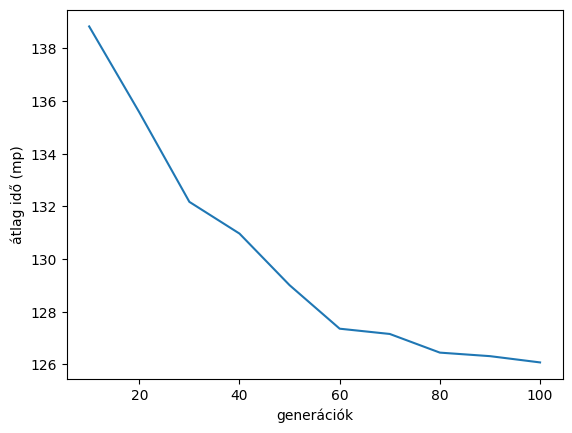

In [14]:
xpoints = np.array(list(range(min_g_a_gens, max_g_a_gens +1 , step)))
ypoints = np.array(f_n)

plt.xlabel("generációk")
plt.ylabel("átlag idő (mp)")

plt.plot(xpoints, ypoints)
plt.show()

In [16]:
avg_fitness, avg_wait, bests = iterateOver(10, 1000)
print(avg_fitness)

120.48000000000002


In [17]:
calls = calls_from_article
crossover_r = 0.8 # ha 0.9 akkor 10% esely van ra
mutation_r = 0.2

go_over_all_crossover_and_mutation_at_rates_with_data(crossover_r, mutation_r, calls, i_max)

E 1 & $ 126.852 $ & $ 116.2 $ & $ 135.8 $ & $ 119.562 $ \\
\hline
E 2 & $ 126.764 $ & $ 116.8 $ & $ 136.4 $ & $ 116.728 $ \\
\hline
E 3 & $ 127.356 $ & $ 115.6 $ & $ 141.0 $ & $ 120.072 $ \\
\hline
E 4 & $ 127.268 $ & $ 115.8 $ & $ 139.4 $ & $ 117.378 $ \\
\hline

E 5 & $ 126.292 $ & $ 114.2 $ & $ 139.6 $ & $ 117.965 $ \\
\hline
E 6 & $ 127.84 $ & $ 113.6 $ & $ 140.0 $ & $ 115.788 $ \\
\hline
E 7 & $ 126.762 $ & $ 113.8 $ & $ 140.6 $ & $ 117.165 $ \\
\hline
E 8 & $ 127.378 $ & $ 115.2 $ & $ 137.6 $ & $ 118.27 $ \\
\hline

E 9 & $ 127.674 $ & $ 113.4 $ & $ 140.4 $ & $ 117.992 $ \\
\hline
E 10 & $ 127.142 $ & $ 117.8 $ & $ 138.8 $ & $ 118.742 $ \\
\hline
E 11 & $ 126.77 $ & $ 116.4 $ & $ 141.8 $ & $ 116.205 $ \\
\hline
E 12 & $ 127.31 $ & $ 116.0 $ & $ 140.4 $ & $ 116.115 $ \\
\hline



In [18]:
i_max =  100
solution, fitness, all_fitness_winners = geneticAlgorithm(
    elevator_start_floor, m, BFT, LT, OT, CT, number_of_genes, calls_from_article, 
    i_max, crossover_rate, mutation_rate, crossover_type, mutation_type)
print(fitness)
print(solution)

121.2
[7, 6, 3, 8, 4, 9, 5, 2, 1, 10]


In [21]:
############### wait time for a passanger

wait_times = calculateWaitTimesForElevatorFromChronosome(elevator_start_floor, calls_from_article, solution, BFT, LT, OT)
print("wait times for each passanger", wait_times)
print("avg wait times for the elevator to arrive in sec", np.mean(wait_times))
print("avg wait times for the elevator to arrive in in min", np.mean(wait_times)/60)

wait times for each passanger [16, 43, 57, 66, 64, 86, 97, 90, 99, 124]
avg wait times for the elevator to arrive in sec 74.2
avg wait times for the elevator to arrive in in min 1.2366666666666668


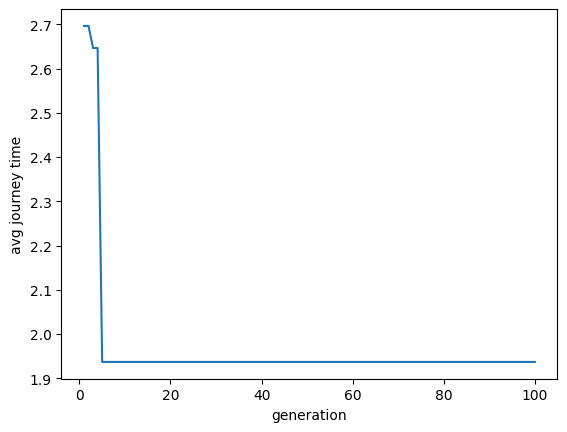

In [77]:
#MINUTES
fitness_winners_minutes = [a/60 for a in all_fitness_winners]

xpoints = np.array(list(range(1, i_max+1)))
ypoints = np.array(fitness_winners_minutes)

plt.xlabel("generation")
plt.ylabel("avg journey time")

plt.plot(xpoints, ypoints)
plt.show()

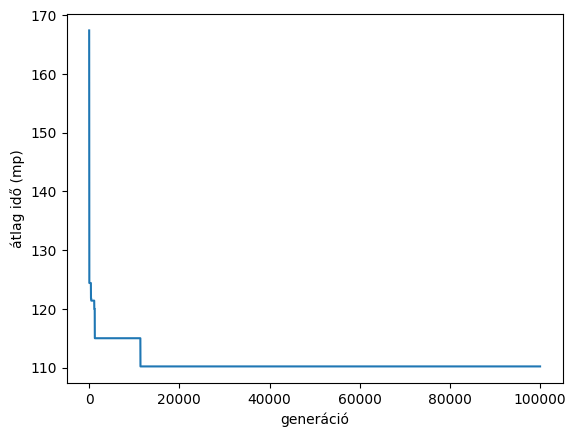

110.2

In [75]:
#SECONDS

xpoints = np.array(list(range(1, i_max+1)))
ypoints = np.array(all_fitness_winners)

plt.xlabel("generáció")
plt.ylabel("átlag idő (mp)")

plt.plot(xpoints, ypoints)
plt.show()

min(all_fitness_winners)

In [76]:
#print(all_fitness_winners[-100:])
print("best in sec", min(all_fitness_winners))
print("best in min", min(all_fitness_winners)/60)

best in sec 110.2
best in min 1.8366666666666667


In [141]:
max_it = 100
sum_fit = 0

bests = []
for i in range(0, max_it):
    solution, fitness, all_fitness_winners = geneticAlgorithm(
        elevator_start_floor, m, BFT, LT, OT, CT, number_of_genes, calls_from_article, 
        i_max, crossover_rate, mutation_rate, crossover_type, mutation_type)
    sum_fit += fitness
    bests.append(fitness)
    
print("avg best in sec", sum_fit/max_it)
print("best in sec", min(bests))
print("worst in sec", max(bests))
print()
print("avg best in min", sum_fit/max_it/60)
print("best in min", min(bests)/60)
print("worst in min", max(bests)/60)

avg best in sec 127.514
best in sec 117.6
worst in sec 139.8

avg best in min 2.125233333333333
best in min 1.96
worst in min 2.33


Case 2 - data from a day

In [52]:
import pandas as pd
mydata=pd.read_csv('file_name.csv')

In [53]:
subdata = mydata.loc[(mydata['year'] == 2019) & (mydata['month'] == 1)  & (mydata['day'] == 1)]
floors = array = subdata['floor'].to_numpy()
destinations = array = subdata['destination'].to_numpy()
calls = []
size = len(floors)

print ("egy napi hivas tomb merete", size)

for i in range(0, size - 1):
    calls.append([floors[i], destinations[i]])

print(calls)

egy napi hivas tomb merete 91
[[0, 8], [0, 2], [0, 17], [0, 3], [0, 11], [0, 12], [0, 10], [2, 1], [0, 9], [2, 1], [0, 19], [9, 6], [0, 19], [2, 0], [0, 6], [0, 14], [10, 8], [0, 20], [19, 14], [0, 17], [0, 8], [19, 1], [0, 15], [0, 9], [0, 9], [16, 15], [11, 0], [0, 14], [0, 14], [0, 11], [0, 10], [0, 15], [19, 10], [16, 2], [0, 7], [19, 10], [0, 9], [0, 14], [16, 8], [0, 12], [0, 1], [0, 10], [0, 18], [2, 0], [0, 17], [2, 1], [16, 12], [0, 11], [11, 4], [2, 1], [11, 1], [0, 4], [2, 1], [4, 3], [0, 16], [9, 7], [12, 10], [2, 0], [0, 18], [2, 0], [2, 1], [16, 9], [16, 10], [0, 11], [0, 8], [18, 11], [0, 16], [2, 0], [0, 14], [12, 8], [0, 16], [9, 1], [8, 4], [7, 3], [0, 8], [0, 1], [0, 5], [10, 7], [12, 7], [0, 15], [0, 11], [14, 5], [0, 8], [10, 7], [10, 4], [10, 7], [0, 9], [0, 19], [10, 5], [2, 0]]


In [81]:
i_max = 100
mutation_rate = 2
mutation_type = 2
solution, fitness, all_fitness_winners = geneticAlgorithm(
    elevator_start_floor, m, BFT, LT, OT, CT, number_of_genes, calls, 
    i_max, crossover_rate, mutation_rate, crossover_type, mutation_type)
print(fitness)

373.2


In [68]:
############### wait time for a passanger

wait_times = calculateWaitTimesForElevatorFromChronosome(elevator_start_floor, calls_from_article, solution, BFT, LT, OT)
print("wait times for each passanger", wait_times)
print("avg wait times for the elevator to arrive in sec", np.mean(wait_times))
print("avg wait times for the elevator to arrive in in min", np.mean(wait_times)/60)

wait times for each passanger [13, 38, 46, 56, 65, 88, 86, 99, 102, 138]
avg wait times for the elevator to arrive in sec 73.1
avg wait times for the elevator to arrive in in min 1.2183333333333333


In [ ]:
#MINUTES
fitness_winners_minutes = [a/60 for a in all_fitness_winners]

xpoints = np.array(list(range(1, i_max+1)))
ypoints = np.array(fitness_winners_minutes)

plt.xlabel("generation")
plt.ylabel("avg journey time")

plt.plot(xpoints, ypoints)
plt.show()

In [154]:
min(all_fitness_winners)

110.2

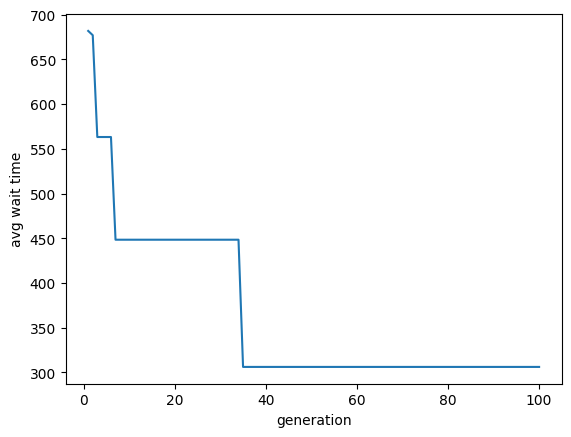

306.2

In [70]:
#SECONDS

xpoints = np.array(list(range(1, i_max+1)))
ypoints = np.array(all_fitness_winners)

plt.xlabel("generation")
plt.ylabel("avg wait time")

plt.plot(xpoints, ypoints)
plt.show()

min(all_fitness_winners)

In [58]:
#print(all_fitness_winners[-100:])
print("best in sec", min(all_fitness_winners))
print("best in min", min(all_fitness_winners)/60)

best in sec 113.2
best in min 1.8866666666666667


In [ ]:
max_it = 100
sum_fit = 0
for i in range(0, max_it):
    solution, fitness, all_fitness_winners = geneticAlgorithm(
        elevator_start_floor, m, BFT, LT, OT, CT, number_of_genes, calls_from_article, 
        i_max, crossover_rate, mutation_rate, crossover_type, mutation_type)
    sum_fit += fitness
print("avg best in sec", sum_fit/max_it)
print("avg best in min", sum_fit/max_it/60)

In [ ]:
max_it = 100
sum_fit = 0

crossover_type = 2
mutation_type = 2

for i in range(0, max_it):
    solution, fitness, all_fitness_winners = geneticAlgorithm(
        elevator_start_floor, m, BFT, LT, OT, CT, number_of_genes, calls_from_article, 
        i_max, crossover_rate, mutation_rate, crossover_type, mutation_type)
    sum_fit += fitness
print("avg best in sec", sum_fit/max_it)
print("avg best in min", sum_fit/max_it/60)

avg best in sec 125.23600000000008
avg best in min 2.0872666666666677


In [26]:
calls

[[5, 0],
 [6, 0],
 [3, 0],
 [11, 0],
 [20, 0],
 [10, 0],
 [13, 0],
 [1, 0],
 [16, 0],
 [18, 0]]

In [25]:
calls
crossover_r = 0.2
mutation_r = 0.8
maxi = 10

go_over_all_crossover_and_mutation_at_rates_with_data(crossover_r, mutation_r, calls, maxi)

E 1 & $ 102.3 $ & $ 102.3 $ & $ 102.3 $ & $ 9.567 $ \\
\hline
E 2 & $ 102.3 $ & $ 102.3 $ & $ 102.3 $ & $ 9.583 $ \\
\hline
E 3 & $ 102.3 $ & $ 102.3 $ & $ 102.3 $ & $ 9.573 $ \\
\hline
E 4 & $ 102.3 $ & $ 102.3 $ & $ 102.3 $ & $ 9.573 $ \\
\hline

E 5 & $ 102.3 $ & $ 102.3 $ & $ 102.3 $ & $ 9.577 $ \\
\hline
E 6 & $ 102.3 $ & $ 102.3 $ & $ 102.3 $ & $ 9.61 $ \\
\hline
E 7 & $ 102.3 $ & $ 102.3 $ & $ 102.3 $ & $ 9.577 $ \\
\hline
E 8 & $ 102.3 $ & $ 102.3 $ & $ 102.3 $ & $ 9.577 $ \\
\hline

E 9 & $ 102.3 $ & $ 102.3 $ & $ 102.3 $ & $ 9.58 $ \\
\hline
E 10 & $ 102.3 $ & $ 102.3 $ & $ 102.3 $ & $ 9.593 $ \\
\hline
E 11 & $ 102.3 $ & $ 102.3 $ & $ 102.3 $ & $ 9.59 $ \\
\hline
E 12 & $ 102.3 $ & $ 102.3 $ & $ 102.3 $ & $ 9.577 $ \\
\hline



case 3 - downpeak

In [222]:
i_max = 100 # generations
m = 4 # population size
crossover_rate = 0.2
mutation_rate = 0.8

#CALLS #[from, to]
calls_from_article = [[5,0], [6,0], [3,0], [11, 0], [20, 0], [10, 0], [13, 0], [1, 0], [16, 10], [1, 0]]
number_of_genes = len(calls_from_article)

# crossover types: 
# 1-order crossover 
# 2-position crossover 
# 3-order based crossover
crossover_type = 1

# mutation types: 
# 1-swap mutation 
# 2-inversion mutation 
# 3-insertion mutation 
# 4-exchange mutation
mutation_type = 1

In [223]:
calls = calls_from_article
crossover_r = 0.8
mutation_r = 0.2

go_over_all_crossover_and_mutation_at_rates_with_data(crossover_r, mutation_r, calls, i_max)

E 1 & $ 104.13 $ & $ 103.6 $ & $ 105.4 $ & $ 92.05 $ \\
\hline
E 2 & $ 104.1 $ & $ 103.6 $ & $ 105.4 $ & $ 92.0 $ \\
\hline
E 3 & $ 103.976 $ & $ 103.6 $ & $ 105.4 $ & $ 91.793 $ \\
\hline
E 4 & $ 104.102 $ & $ 103.6 $ & $ 105.4 $ & $ 92.003 $ \\
\hline

E 5 & $ 104.022 $ & $ 103.6 $ & $ 105.4 $ & $ 91.87 $ \\
\hline
E 6 & $ 104.268 $ & $ 103.6 $ & $ 105.4 $ & $ 92.28 $ \\
\hline
E 7 & $ 104.082 $ & $ 103.6 $ & $ 105.4 $ & $ 91.97 $ \\
\hline
E 8 & $ 104.064 $ & $ 103.6 $ & $ 105.4 $ & $ 91.94 $ \\
\hline

E 9 & $ 103.994 $ & $ 103.6 $ & $ 105.4 $ & $ 91.823 $ \\
\hline
E 10 & $ 104.14 $ & $ 103.6 $ & $ 105.4 $ & $ 92.067 $ \\
\hline
E 11 & $ 104.154 $ & $ 103.6 $ & $ 105.4 $ & $ 92.09 $ \\
\hline
E 12 & $ 104.02 $ & $ 103.6 $ & $ 105.4 $ & $ 91.867 $ \\
\hline



In [19]:
i_max =  100
solution, fitness, all_fitness_winners = geneticAlgorithm(
    elevator_start_floor, m, BFT, LT, OT, CT, number_of_genes, calls_from_article, 
    i_max, crossover_rate, mutation_rate, crossover_type, mutation_type)
print(fitness)

102.3


In [20]:
############### wait time for a passanger

wait_times = calculateWaitTimesForElevatorFromChronosome(elevator_start_floor, calls_from_article, solution, BFT, LT, OT)
print("wait times for each passanger", wait_times)
print("avg wait times for the elevator to arrive in sec", np.mean(wait_times))
print("avg wait times for the elevator to arrive in in min", np.mean(wait_times)/60)

wait times for each passanger [23, 32, 28, 47, 49, 53, 66, 81, 89, 106]
avg wait times for the elevator to arrive in sec 57.4
avg wait times for the elevator to arrive in in min 0.9566666666666667


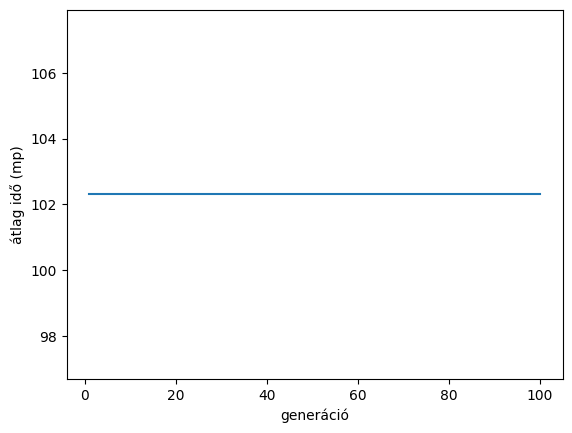

102.3

In [21]:
#SECONDS

xpoints = np.array(list(range(1, i_max+1)))
ypoints = np.array(all_fitness_winners)

plt.xlabel("generáció")
plt.ylabel("átlag idő (mp)")

plt.plot(xpoints, ypoints)
plt.show()

min(all_fitness_winners)

In [22]:
#print(all_fitness_winners[-100:])
print("best in sec", min(all_fitness_winners))
print("best in min", min(all_fitness_winners)/60)

best in sec 102.3
best in min 1.7049999999999998


In [23]:
max_it = 100
sum_fit = 0

bests = []
for i in range(0, max_it):
    solution, fitness, all_fitness_winners = geneticAlgorithm(
        elevator_start_floor, m, BFT, LT, OT, CT, number_of_genes, calls_from_article, 
        i_max, crossover_rate, mutation_rate, crossover_type, mutation_type)
    sum_fit += fitness
    bests.append(fitness)
    
print("avg best in sec", sum_fit/max_it)
print("best in sec", min(bests))
print("worst in sec", max(bests))
print()
print("avg best in min", sum_fit/max_it/60)
print("best in min", min(bests)/60)
print("worst in min", max(bests)/60)

avg best in sec 102.29999999999997
best in sec 102.3
worst in sec 102.3

avg best in min 1.7049999999999994
best in min 1.7049999999999998
worst in min 1.7049999999999998
